In [37]:
import collections
import heapq
import matplotlib.pyplot as plt
import numpy as np
import os, time, json
import pickle

import itertools, sys, math, time
from scipy.spatial import distance as dist
from numpy import linalg

from matplotlib import offsetbox
from scipy.sparse import csr_matrix
from sklearn import cluster, datasets, decomposition, ensemble, lda, manifold, random_projection
from sklearn.decomposition import TruncatedSVD

from sklearn import svm, grid_search
from sklearn.decomposition import PCA, SparsePCA
from scipy import sparse as sp

from sklearn import cluster

%matplotlib inline

In [3]:
def sparse_where(sparse_matrix, num):
    """
    np.where() for a sparse matrix. Returns a set of indices.
    """
    return set(np.where(sparse_matrix[num,:].toarray())[1].tolist())

def sparse_vals(row):
    return row[np.where(row.toarray())[0]]


In [4]:
# Skip parts that take a long time.
SKIP_LONG_PARTS = True

# Create a dense representation of the data.
CREATE_DENSE_ARRAY = False

NUM_SPEECHES = 2740

NUM_DEBATES = 38

In [5]:
def load_sparse_data(filename, num_lines):
    """
    Function to load sparse data.
    """
    inverted_index = collections.defaultdict(set)
    
    sparse_indptr = [0]
    sparse_indices = []
    sparse_data = []
    vocabulary = {}

    print 'Reading data.'
    for line_num, line in enumerate(open(filename)):
        new_row = [(idx,float(prob)) for idx, prob in enumerate(line.strip().split(',')) if float(prob) > 0.0]
        for i,p in new_row:
            sparse_indices.append(i)
            sparse_data.append(p)
            inverted_index[i].add(line_num)
        sparse_indptr.append(len(sparse_indices))
        sys.stdout.write("\r%d%%" % (100.0 * line_num / num_lines))
        sys.stdout.flush()
    print 100.0 * line_num / num_lines, '%'
    print 'Done reading data.'

    sparse_matrix = csr_matrix((sparse_data, sparse_indices, sparse_indptr), dtype=float)
    return sparse_matrix, inverted_index

In [6]:
speech_vectors, inverted_index = load_sparse_data('speech_vectors.csv', NUM_SPEECHES)

Reading data.
99%99.9635036496 %
Done reading data.


In [170]:
speech_graph, inverted_graph = load_sparse_data('speech_graph.csv', NUM_SPEECHES)

Reading data.
99%99.9635036496 %
Done reading data.


## TF-IDF Matrix

In [74]:
def sparse_cosine_sim(X, Y):
    dot = s1.dot(s2.T)
    norm = (math.sqrt(s1.dot(s1.T).sum()) * math.sqrt(s2.dot(s2.T).sum()))
    if not dot.data or norm == 0:
        return 0
    return dot.data[0]/norm

def cosine_sim(X, Y):
    dot = s1.dot(s2.T)
    norm = (math.sqrt(s1.dot(s1.T).sum()) * math.sqrt(s2.dot(s2.T).sum()))
    return dot/norm if norm != 0 else 0

def cosine_similarity(X, Y):
    """
    Calculates cosine Similarity of two vectors
    Inputs:
        X : The question vectors (sparse or dense matrix)
        Y : The passage vectors (sparse or dense matrix)
    Outputs:
        Consine Similarity
    !!!!MAKE SURE DOC IS SECOND ARGUMENT!!!!! (the Y)
    """
    def dense_cosine_sim(X,Y):
        denom = np.linalg.norm(Y) * np.linalg.norm(X)
        return np.dot(X,Y)/denom if denom !=0 else 0
    def is_array(X):
        return isinstance(X, list) or isinstance(X, (np.ndarray, np.generic) )
    return dense_cosine_sim(X,Y) if is_array(X) and is_array(Y) else sparse_cosine_sim(X,Y)

In [45]:
import math
from scipy import sparse as sp
def compute_idf(inv_idx, tf_matrix, min_df=10, max_df_ratio=0.95):
    """ 
    =Inputs=
    inv_idx: an inverted index as above
    tf: matrix
        sprase matrix of tf
    min_df: int,
        Minimum number of documenats a term must occur in.
        Less frequent words get ignored.
    max_df_ratio: float,
        Maximum ratio of documents a term can occur in.
        More frequent words get ignored.
    =Outputs=
    idf vector
    """
    idf = []
    n_docs  = tf_matrix.shape[0]
    n_terms = tf_matrix.shape[1]
    cut_count = 0
    for term_idx in xrange(25000, 25000+n_terms):
        df = float(len(inv_idx[term_idx]))
        if (df >= min_df) and ((df/n_docs) <= max_df_ratio):
            idf.append(math.log(n_docs/(1 + df)))
        else:
            cut_count += 1
            idf.append(0)
    print "cut off this many with df stuff:", cut_count
    print "% data cut: ", (cut_count/float(n_terms))
    return idf

# tf_matrix = speech_vectors[:,25000:]
# idf = compute_idf(inverted_index, tf_matrix, min_df=3, max_df_ratio=(249 / float(2740)))

# print tf_matrix.shape, csr_matrix(idf).T.shape
# tfidf_matrix = tf_matrix.multiply(csr_matrix(idf))

tfidf_matrix = pickle.load(open('files/tfidf_matrix_sparse.p', 'r'))
print tfidf_matrix.shape

(2740, 25000)


##Random Projection

In [330]:
# run PCA on data
# truncated_svd = TruncatedSVD(n_components=10)
# tfidf_matrix_reduced = truncated_svd.fit_transform(tfidf_matrix[:, :25000])

# Sparse random projection to reduce dimensionality

# transformer = random_projection.GaussianRandomProjection(n_components=1000)
transformer = random_projection.SparseRandomProjection(n_components=300)
tfidf_matrix_reduced = transformer.fit_transform(tfidf_matrix[:, :25000])
print tfidf_matrix_reduced.shape

sims = np.zeros((2740, 2740))
print 'done'

tfidf_matrix_reduced = tfidf_matrix_reduced.toarray()

(2740, 300)
done


##Get cosine similarities

2730# sims: 7507600
done


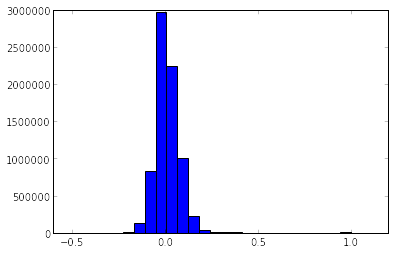

In [331]:
start = time.time()
for i in range(0, 2740):
    s1 = tfidf_matrix_reduced[i]
    if i %10 == 0:
        sys.stdout.write('\r')
        sys.stdout.write("%d" % (i))
        sys.stdout.flush()
    
    for j in range(i, 2740):
        s2 = tfidf_matrix_reduced[j]
        sim = cosine_sim(s1, s2)
        sims[i][j] = sim
        sims[j][i] = sim

# np.savetxt('files/sims_matrix.txt', sims)
all_sims = sims.flatten()
print '# sims: ' + str(len(all_sims))
plt.hist(all_sims, bins=25)

print 'done'

## TF-IDF and Stopping // not used

In [332]:
# avg_word_freqs = {}
# for row in range(2740):
#     sys.stdout.write('\rrow %d' % row)
#     sys.stdout.flush()
#     for word, freq in enumerate(speech_vectors[row].toarray()[0]):
#         if freq == 0: continue
#         if word not in avg_word_freqs:
#             avg_word_freqs[word] = 0
#         avg_word_freqs[word] += freq

# for word in avg_word_freqs.keys():
#     avg_word_freqs[word] /= 2740.0


In [333]:
# plt.hist(avg_word_freqs.values(), bins=50)

##Create SVM training set

37
# labels: 1945


(array([43, 59, 45, 44, 39, 53, 21, 80, 62, 67, 76, 75, 23, 40, 70, 63, 20,
        63, 67, 49, 58, 61, 55, 50, 56, 46, 16, 33, 50, 52, 49, 61, 55, 38,
        41, 65, 59, 41]),
 array([  0.        ,   0.97368421,   1.94736842,   2.92105263,
          3.89473684,   4.86842105,   5.84210526,   6.81578947,
          7.78947368,   8.76315789,   9.73684211,  10.71052632,
         11.68421053,  12.65789474,  13.63157895,  14.60526316,
         15.57894737,  16.55263158,  17.52631579,  18.5       ,
         19.47368421,  20.44736842,  21.42105263,  22.39473684,
         23.36842105,  24.34210526,  25.31578947,  26.28947368,
         27.26315789,  28.23684211,  29.21052632,  30.18421053,
         31.15789474,  32.13157895,  33.10526316,  34.07894737,
         35.05263158,  36.02631579,  37.        ]),
 <a list of 38 Patch objects>)

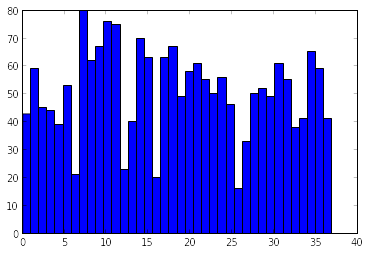

In [334]:
original_cluster_labels = []
cluster_labels = {}

# populate cluster labels with initial given
with open('files/hint.csv', 'r') as labels_file:
    for line in labels_file:
        vals = line.split(',')
        row = int(vals[0])
        label = int(vals[1].strip())
        original_cluster_labels.append( (row, label) )
        cluster_labels[row] = (label, 99)

# propogate labels with similar rows based on cosine similarity
sim_count = 0
for row, label in original_cluster_labels:
    row_sims = sorted([(i, sim) for i, sim in enumerate(sims[row])], reverse=True, key=lambda pair: pair[1])
    sys.stdout.write('\r%d' % label)
    sys.stdout.flush()
#     for i, sim in enumerate(sims[row]):
#         if i == row: continue
#         if sim > 0.9:
#             sim_count += 1
#             if i not in cluster_labels:
#                 cluster_labels[i] = (label, sim)
#             else:
#                 _, old_sim = cluster_labels[i]
#                 if sim > old_sim:
#                     cluster_labels[i] = (label, sim)
    for (i, sim) in row_sims[:100]:
        if i == row: continue
        if i not in cluster_labels:
            cluster_labels[i] = (label, sim)
        else:
            _, old_sim = cluster_labels[i]
            if sim > old_sim:
#                 print row, i, old_sim, sim, label
                cluster_labels[i] = (label, sim)
                
# print '# similar speeches: ' + str(sim_count)
print '\n# labels: ' + str(len(cluster_labels))
# print zip(*cluster_labels)[1]
label_freqs = list(zip(*cluster_labels.values())[0])
label_freqs.sort()

# print label_freqs
# groups = [(key, len(list(group))) for key, group in itertools.groupby(label_freqs)]
# print (groups)

plt.hist(label_freqs, bins=38)


In [335]:
# plt.hist(sims[5], bins=25)

## SVM Multiclass

In [336]:
# construct SVM training input
X = []
Y = []
for row, (label, sim) in cluster_labels.iteritems():
    X += [tfidf_matrix_reduced[row]]
    Y += [label]
X = np.array(X)
Y = np.array(Y)
print X.shape, Y.shape
# plt.hist(Y, bins=25)

# train SVM, searching over paramaters
parameters = {'C':np.arange(1, 10, 0.5)}

lin_clf = svm.LinearSVC()
clf = grid_search.GridSearchCV(lin_clf, parameters)
print clf.fit(X, Y)

(1945, 300) (1945,)
GridSearchCV(cv=None,
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)


(array([ 50,  96,  51,  43,  63,  79,  12, 148,  79, 116, 134,  99,  16,
         34, 104,  92,   7,  92,  96,  60,  80, 105,  62,  59,  90, 190,
          0,  28,  65,  79,  56,  99,  72,  43,  47,  75,  71,  48]),
 array([  0.        ,   0.97368421,   1.94736842,   2.92105263,
          3.89473684,   4.86842105,   5.84210526,   6.81578947,
          7.78947368,   8.76315789,   9.73684211,  10.71052632,
         11.68421053,  12.65789474,  13.63157895,  14.60526316,
         15.57894737,  16.55263158,  17.52631579,  18.5       ,
         19.47368421,  20.44736842,  21.42105263,  22.39473684,
         23.36842105,  24.34210526,  25.31578947,  26.28947368,
         27.26315789,  28.23684211,  29.21052632,  30.18421053,
         31.15789474,  32.13157895,  33.10526316,  34.07894737,
         35.05263158,  36.02631579,  37.        ]),
 <a list of 38 Patch objects>)

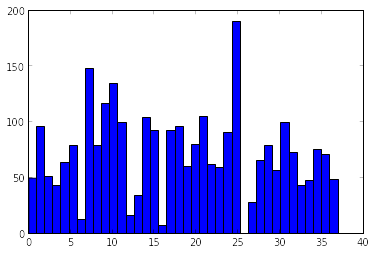

In [337]:
predictions = clf.predict(tfidf_matrix_reduced)

groups = [(key, len(list(group))) for key, group in itertools.groupby(predictions)]
# print groups

plt.hist(predictions, bins=38)

In [341]:
# Compare to Josh's 97% output
good_preds = np.loadtxt(open('files/hacky1.csv'),delimiter=",",skiprows=1)

good_preds_dict = {}
for row, pred in good_preds:
    good_preds_dict[row] = pred

# relabel predictions according to original labels
label_map = {}
for row, label in original_cluster_labels:
    print predictions[row]
    label_map[predictions[row]] = label
print label_map

common_count = 0.0
for row, pred in enumerate(predictions):
    if pred in label_map and label_map[pred] == good_preds_dict[row]:
        common_count+=1
print common_count/2740


0
1
2
3
4
5
4
7
8
9
10
11
36
13
14
15
25
17
18
19
20
21
22
23
24
25
4
27
28
29
30
31
32
33
34
35
36
37
{0: 0, 1: 1, 2: 2, 3: 3, 4: 26, 5: 5, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 13: 13, 14: 14, 15: 15, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37}
0.193795620438


## Spectral cutting

In [244]:
rows_over_635 = np.array(json.loads(open('files/rows_over_365.json', 'r').read()))
print 'done'

done


(922, 922)


(array([282,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 344,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 296]),
 array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
         0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
         0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
         0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ,
         1.05263158,  1.10526316,  1.15789474,  1.21052632,  1.26315789,
         1.31578947,  1.36842105,  1.42105263,  1.47368421,  1.52631579,
         1.57894737,  1.63157895,  1.68421053,  1.73684211,  1.78947368,
         1.84210526,  1.89473684,  1.94736842,  2.        ]),
 <a list of 38 Patch objects>)

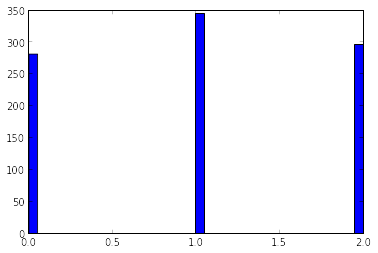

In [245]:
# spectral = SpectralClustering(n_clusters=4)

vectors_big_clusters = speech_graph[rows_over_635]
vectors_big_clusters = vectors_big_clusters[:, rows_over_635]

print vectors_big_clusters.shape
spectral_labels = cluster.spectral_clustering(vectors_big_clusters, n_clusters=3)
plt.hist(spectral_labels, bins=38)

In [246]:
speech_graph_copy, _ = load_sparse_data('speech_graph.csv', NUM_SPEECHES)

speech_row_sums = {i: len(sparse_where(speech_graph, i)) for i in range(NUM_SPEECHES)}
print 'done'

Reading data.
99%99.9635036496 %
Done reading data.
done


In [247]:
# Create affinity matrix.
print 'Creating affinity matrix.'
for row in range(NUM_SPEECHES):
    row_indices = sparse_where(speech_graph, row)
    sys.stdout.write('\r%d' % (row))
    sys.stdout.flush()
    for col in row_indices:
        if speech_row_sums[col] <= 634 :
            speech_graph_copy[row, col] = 0.0

print 'Done'

Creating affinity matrix.
3

KeyboardInterrupt: 

In [ ]:
speech_graph_copy_sums = {i: len(sparse_where(speech_graph_copy, i)) for i in range(NUM_SPEECHES)}

In [224]:
rows_over_635 = [i for i in range(NUM_SPEECHES) if speech_row_sums[i] > 635]
rows_over_635_trimmed = [i for i in range(2740) if i in rows_over_635 and speech_graph_copy_sums[i] > 250]
print 'done'

## KMeans

In [317]:
# construct centroids
X = []
Y = []
centroid_rows = {}
for row, (label, sim) in cluster_labels.iteritems():
    if label not in centroid_rows:
        centroid_rows[label] = []
    centroid_rows[label] += [tfidf_matrix_reduced[row]]
    
centroids = []
for label in centroid_rows.keys():
    centroids.append([x/len(centroid_rows[label]) for x in [sum(col) for col in zip(*centroid_rows[label])]])
centroids = np.array(centroids)

print centroids[0].shape
print len(centroids)

#     X += [tfidf_matrix_reduced[row]]
#     Y += [label]
# X = np.array(X)
# Y = np.array(Y)


(300,)
38


(array([  13,   29,  227,    1,    1,   18,    1,    7,    1,    8,    8,
           1,    5,   36,   57,   71,   13,   22,   34,   30,   13, 1512,
           3,    1,    1,   13,    1,   10,   40,    5,   43,  398,   22,
           6,   42,    5,    4,   38]),
 array([  0.        ,   0.97368421,   1.94736842,   2.92105263,
          3.89473684,   4.86842105,   5.84210526,   6.81578947,
          7.78947368,   8.76315789,   9.73684211,  10.71052632,
         11.68421053,  12.65789474,  13.63157895,  14.60526316,
         15.57894737,  16.55263158,  17.52631579,  18.5       ,
         19.47368421,  20.44736842,  21.42105263,  22.39473684,
         23.36842105,  24.34210526,  25.31578947,  26.28947368,
         27.26315789,  28.23684211,  29.21052632,  30.18421053,
         31.15789474,  32.13157895,  33.10526316,  34.07894737,
         35.05263158,  36.02631579,  37.        ]),
 <a list of 38 Patch objects>)

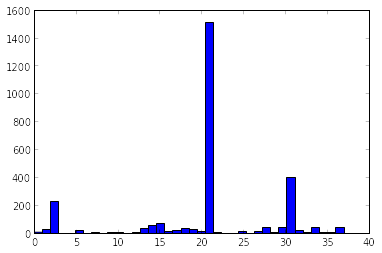

In [343]:
k_means = cluster.KMeans(n_clusters=len(centroids), init=centroids, n_init=1)
k_means.fit(tfidf_matrix_reduced)

labels = k_means.labels_
plt.hist(labels, bins=38)

In [344]:
# Compare to Josh's 97% output
good_preds = np.loadtxt(open('files/hacky1.csv'),delimiter=",",skiprows=1)

good_preds_dict = {}
for row, pred in good_preds:
    good_preds_dict[row] = pred

common_count = 0.0
for row, pred in enumerate(labels):
    if pred == good_preds_dict[row]:
        common_count+=1
print common_count/2740


0.0164233576642
